In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# 5.2 Simple use of Bayes's rule

Consider the probability model
```
def ry():
    θ = np.random.uniform(0,1)
    y = np.random.binomial(n=3, p=θ)
    return y
```
Suppose we have observed $Y=2$ and we want to know the likely range of $\Theta$. Plot a histogram of $(\Theta|Y=2)$.

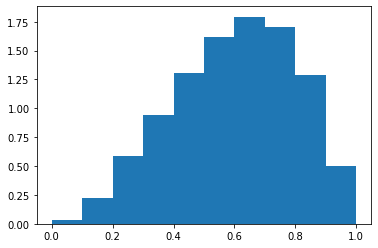

In [9]:
# Step 1. Generate a sample from Θ
θsamp = np.random.uniform(0,1, size=10000)

# Step 2. For each sample value θ[i], compute a weight w[i] = Pr(y|Θ=θ[i]), and rescale
# (we could look up the formula for Pr(y), and type it out, but why not use the library routine?)
w = scipy.stats.binom.pmf(2, n=3, p=θsamp)
w = w / np.sum(w)

# Step 3. Reason about (Θ|Y=y) via this weighted sample
plt.hist(θsamp, weights=w, density=True)
plt.show()

# 7.1 Finding the posterior
## Example: coin tossing

I have a coin, which might be biased. I toss it $n=10$ times and get $x=9$ heads.
Let $\Theta$ be the probability of heads, an unknown parameter. Using the prior distribution
$\Theta\sim U[0,1]$, find the posterior distribution.

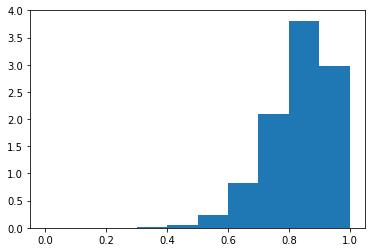

In [14]:
# Step 1. Generate a sample from Θ
θsamp = np.random.uniform(0,1, size=10000)

# Step 2. For each sample value θ[i], compute a weight w[i] = Pr(x|Θ=θ[i]), and rescale
n,x = 10,9
w = scipy.stats.binom.pmf(x, n=n, p=θsamp)
w = w / np.sum(w)

# Alternatively, use the pmf formula; we might as well ignore non-θ factors
w = θsamp**x * (1-θsamp)**(n-x)
w = w / np.sum(w)

# Step 3. Reason about (Θ|Y=y) via this weighted sample
plt.hist(θsamp, weights=w, density=True)
plt.show()

## Example: multiple unknowns

We have a random sample $x=(x_1,\dots,x_n)$ drawn from $X\sim U[a,a+b]$ where $a$ and $b$ are unknown parameters.
Using $A\sim\operatorname{Exp}(\lambda_0)$ and $B\sim\operatorname{Exp}(\mu_0)$ as prior distributions,
where $\lambda_0=0.2$ and $\mu_0=0.1$, find the posterior distribution of $B$, for the data
```
x = [2, 3, 2.1, 2.4, 3.14, 1.8]
```

In [16]:
λ0, μ0 = 0.2, 0.1
x = [2, 3, 2.1, 2.4, 3.14, 1.8]

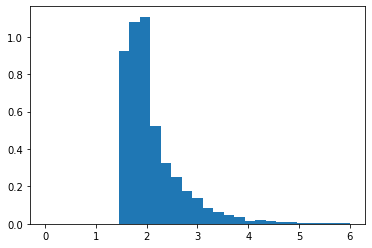

In [19]:
# Step 1. Generate a sample from (A,B)
# We really want to generate a list of (a,b) samples ...
# but we'll assume that, under the prior, A and B are independent,
# and so we might as well generate them as two 'unzipped' lists.
asamp = np.random.exponential(scale=1/λ0, size=10000)
bsamp = np.random.exponential(scale=1/μ0, size=10000)

# Step 2. For each sample value (a,b)[i], compute a weight w[i] = Pr(x1...xn|A=a[i], B=b[i]), and rescale
# The likelihood for a single observation is Pr(x|a,b)=1/b * 1[x>=a and x<=a+b]
# So the likelihood for the dataset is Pr(x1...xn|a,b) = (1/b)**n * 1[a <= min xi] * 1[max xi <= a+b]
n,minx,maxx = len(x), min(x), max(x)
w = np.power(1/bsamp, n) * np.where(asamp<=minx,1,0) * np.where(maxx<=asamp+bsamp,1,0)
w = w / np.sum(w)

# Step 3. Reason about (A,B|X=x) via this weighted sample
plt.hist(bsamp, weights=w, density=True, bins=np.linspace(0,6,30))
plt.show()

The posterior distribution only places any weight at all on $(a,b)$ samples such that
all the data lies in $[a, a+b]$, i.e. where $a \leq \min_i x_i = 1.8$ and $a+b \geq \max_i x_i= 3.14$.
Any other $(a,b)$ is impossible.

Interestingly, this means that $(A,B|x)$ are not independent, whereas 
under the prior $A$ and $B$ are independent.

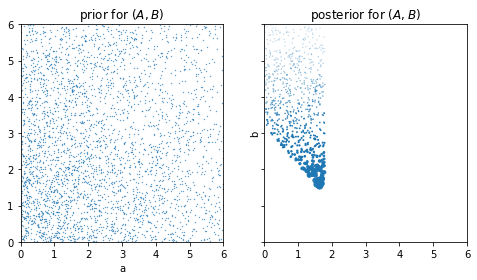

In [27]:
fig,(ax_prior,ax_post) = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)
ax_prior.scatter(asamp, bsamp, s=1/len(asamp)*1000)
ax_post.scatter(asamp, bsamp, s=w*1000)
ax_prior.set_xlim([0,6])
ax_prior.set_ylim([0,6])
ax_prior.set_xlabel('a')
ax_post.set_ylabel('b')
ax_prior.set_title('prior for $(A,B)$')
ax_post.set_title('posterior for $(A,B)$')
plt.show()

## Avoiding underflow

I toss a coin, which might be biased. I toss it $n=10$ times and get $x_1=9$ heads. I do four more repeats of this experiment, and get $[x_2,x_3,x_4,x_5]=[9,10,8,10]$ heads.
Let $\Theta$ be the probability of heads.
Using the prior $\Theta\sim U[0,1]$, find the posterior distribution.

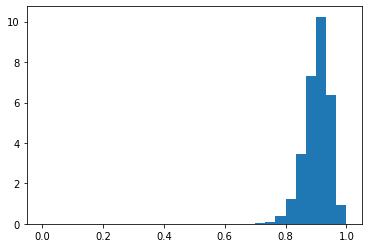

In [31]:
# Step 1. Generate a sample from Θ
θsamp = np.random.uniform(0,1, size=10000)

# Step 2. For each sample value θ[i], compute a weight w[i] = Pr(x|Θ=θ[i]), and rescale.
# Here x is the entirety of the observed data.
# If we just multiply lots of probabilities together we're in danger of underflow,
# so we should compute w with more cunning ...
n,x = 10, [9,9,10,8,10]
# First compute log(w[i]).
logw = np.array([np.sum(scipy.stats.binom.logpmf(x, n=n, p=θ)) for θ in θsamp])
# Then add a well-chosen constant to log(w[i]). This is equivalent to multiplying w[i] by a constant,
# and the constant cancels out when we normalize w. We'll choose the constant so that
# the largest w[i] is 1, before rescaling, so we're guaranteed that something survives the rescaling
# without underflow.
κ = np.max(logw)
w = np.exp(logw - κ)
w = w / np.sum(w)

# Step 3. Reason about (Θ|Y=y) via this weighted sample
plt.hist(θsamp, weights=w, density=True, bins=30)
plt.show()

# 7.2 Readouts from Bayesian calculations

Given `θsamp` and `w` from the previous exercise, report a 95% confidence interval for $\Theta$.

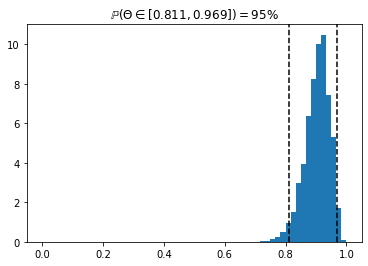

In [38]:
i = np.argsort(θsamp)
θsamp, w = θsamp[i], w[i]
F = np.cumsum(w)
(lo,hi) = (θsamp[F<0.025][-1], θsamp[F>0.975][0])

fig,ax = plt.subplots()
ax.hist(θsamp, weights=w, density=True, bins=60)
ax.axvline(x=lo, linestyle='--', color='black')
ax.axvline(x=hi, linestyle='--', color='black')
ax.set_title(r'$\mathbb{P}(\Theta\in'+f'[{lo:.3},{hi:.3}]'+')=95\%$')
plt.show()